In [ ]:
import networkx as nx
from thewalrus import hafnian
import numpy as np
import random 
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"font.size": 16})

# 启用 LaTeX 渲染
plt.rcParams["text.usetex"] = True
# Number of vertexes
n = 256
p = 0.4

# 创建 Erods-Renyi Graph
G0 = nx.erdos_renyi_graph(n, p, seed=7)

np.save(f'./Data/{n}/G0.npy', nx.to_numpy_array(G0))
# G0 = nx.from_numpy_array(np.load(f'./Data/{n}/G0.npy'))

# 为每条边赋予随机的复数权重
# np.random.seed(7)
# for (u, v) in G0.edges():
#     real_part = np.random.uniform(-1, 1)   # 随机实部
#     imag_part = np.random.uniform(-1, 1)   # 随机虚部
#     G0[u][v]['weight'] = complex(real_part, imag_part)

def calculate_hafnian(subgraph):
    # Convert the subgraph to an adjacency matrix
    adj_matrix = nx.to_numpy_array(subgraph)
    return abs(hafnian(adj_matrix))

# G2 = nx.from_numpy_array(np.load(f'./Data/{n}/G2.npy'))

def calculate_density(subgraph):
    # Calculate the density of the subgraph
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    if num_nodes < 2:
        return 0  # Avoid division by zero
    density = num_edges / num_nodes
    return density

print(calculate_density(G0))

51.5


In [19]:
# Initial matching is empty set
def glauber_dynamics(G, k, c, mixing_time):
    matching = set()
    post_select_subgraph = list()
    
    for _ in range(mixing_time):
        # Randomly select an edge
        e = random.choice(list(G.edges()))
        u, v = e
        # Check the status of the selected edge
        if all(node not in list(n for edge in matching for n in edge) for node in e):
            # Both u and v are not in the matching
            if np.random.rand() <= c**2 / (1 + c**2):
                matching.add(e)
        elif e in matching:
            # Both u and v are in the matching
            if np.random.rand() <= 1 / (1 + c**2):
                matching.remove(e)
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))
        
    return post_select_subgraph[-1]

def modified_glauber_dynamics(G, k, c, mixing_time):
    return 

def random_search(G, k, iteration):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d submatrix of A, randomly
        Ai = random.sample(nodes, k)
        Ai_subgraph = G.subgraph(Ai)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def modified_glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = modified_glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_hafnian(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

100%|██████████| 10/10 [36:07<00:00, 216.77s/it]


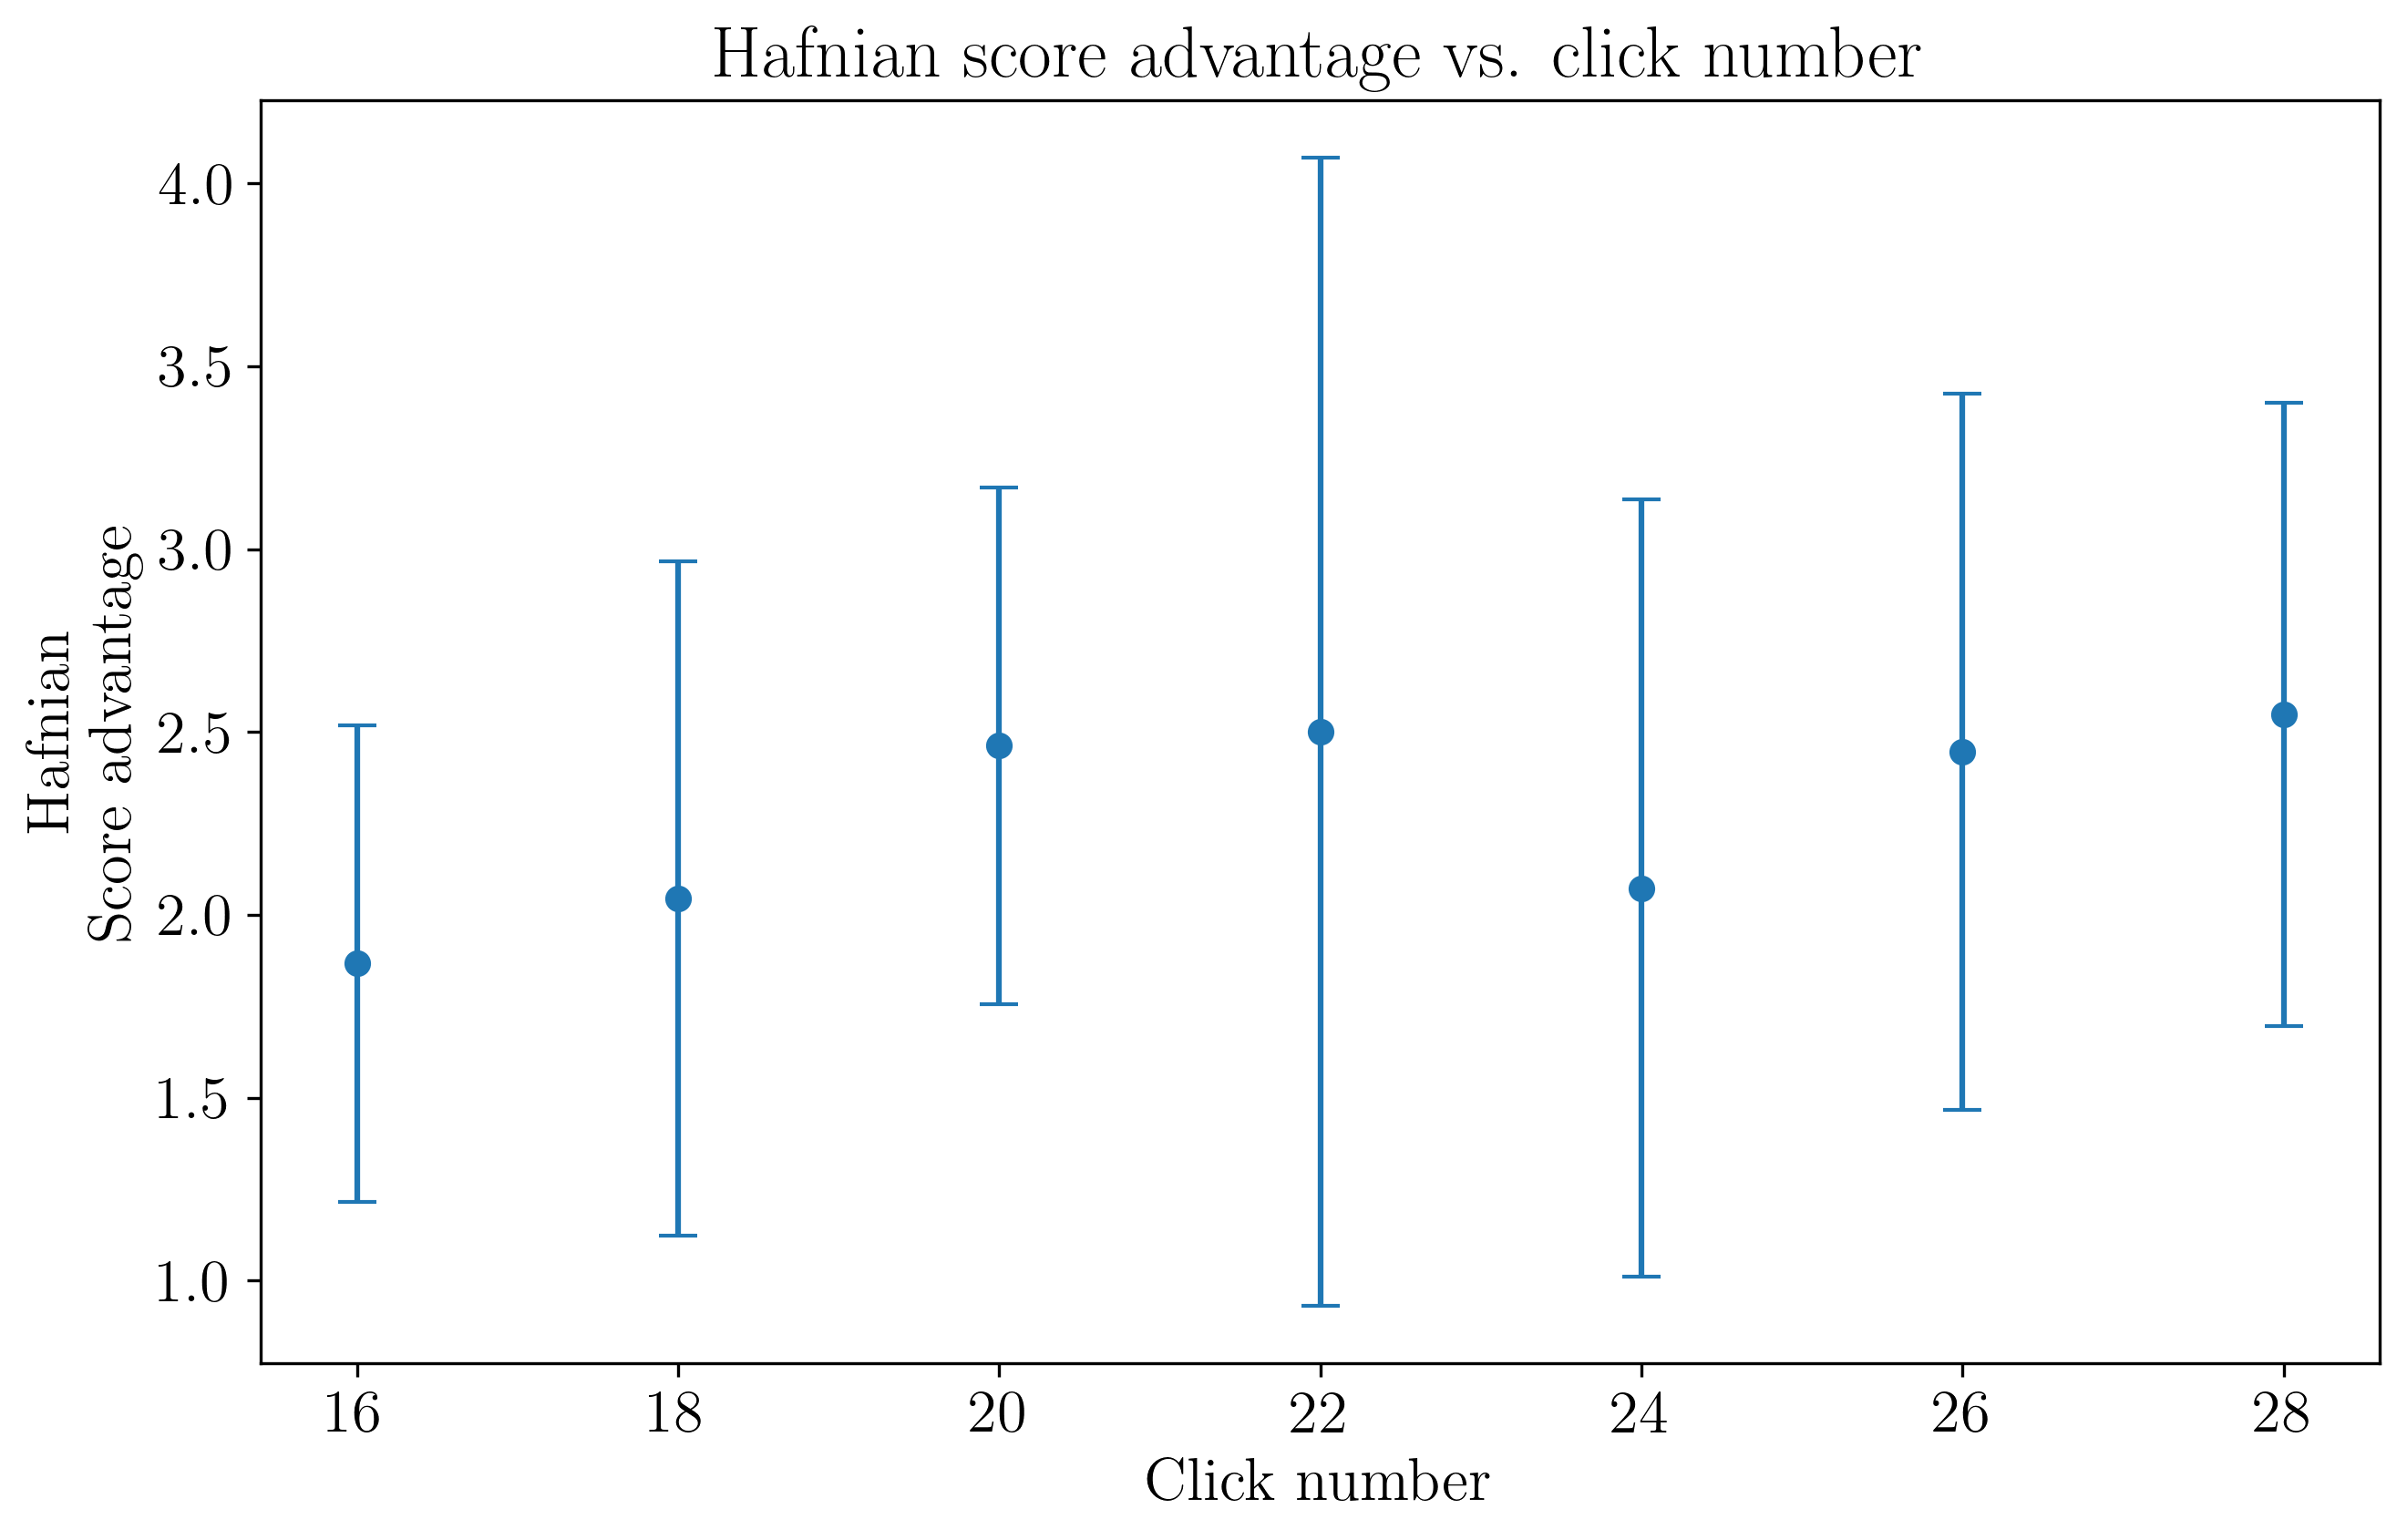

In [10]:
# Plot the hafnian score advantage versus click number
c = 0.4 # fugacity
iteration = 100
mixing_time = 1000
click_number_list = [16, 18, 20, 22, 24, 26, 28]

plt.figure(figsize=(10, 6), dpi=300)
for k in click_number_list:
    best_hafnian = np.zeros(10)
    glauber_best_hafnian = np.zeros(10)
    modified_glauber_best_hafnian = np.zeros(10)
    for i in tqdm(range(10)):
        _, _, best_hafnian[i] = random_search(G0, k, iteration)
        _, _, glauber_best_hafnian[i] = glauber_random_search(G0, k, c, iteration, mixing_time)
        # _, _, modified_glauber_best_hafnian[i] = modified_glauber_random_search(G2, k, c, iteration, mixing_time)
    score_advantage = glauber_best_hafnian / best_hafnian
    np.save(f"./Data/{n}/hafnian_score_advantage_{k}.npy", score_advantage)
    mean = np.mean(score_advantage, axis=0)
    std = np.std(score_advantage, axis=0)
    plt.errorbar(k, mean, yerr = std, fmt='o', color='C0', ecolor='C0', capsize=5)
    
plt.xlabel('Click number')
plt.ylabel('Hafnian \n Score advantage')
plt.title('Hafnian score advantage vs. click number')
plt.savefig('./Figure/hafnian_score_advantage.pdf')
plt.show()

In [4]:
print(best_hafnian)
print(glauber_best_hafnian)

[1.70236038e+14 1.83388304e+14 1.63515209e+14 1.63263242e+14
 1.57843170e+14 1.76679950e+14 1.56554888e+14 1.68814035e+14
 1.58096870e+14 1.69959122e+14]
[1.70236038e+14 1.76956866e+14 1.63792125e+14 1.57360067e+14
 1.63527684e+14 1.64045268e+14 1.97962574e+14 1.76403655e+14
 1.83388304e+14 1.70236038e+14]


In [15]:
# Initial matching is empty set
def glauber_dynamics(G, k, c, mixing_time):
    matching = set()
    post_select_subgraph = list()
    
    for _ in range(mixing_time):
        # Randomly select an edge
        e = random.choice(list(G.edges()))
        u, v = e
        # Check the status of the selected edge
        if all(node not in list(n for edge in matching for n in edge) for node in e):
            # Both u and v are not in the matching
            if np.random.rand() <= c**2 / (1 + c**2):
                matching.add(e)
        elif e in matching:
            # Both u and v are in the matching
            if np.random.rand() <= 1 / (1 + c**2):
                matching.remove(e)
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))
        
    return post_select_subgraph[-1]

def modified_glauber_dynamics(G, k, c, mixing_time):
    return 

def random_search(G, k, iteration):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d submatrix of A, randomly
        Ai = random.sample(nodes, k)
        Ai_subgraph = G.subgraph(Ai)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def modified_glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = modified_glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

100%|██████████| 10/10 [19:25<00:00, 116.54s/it]


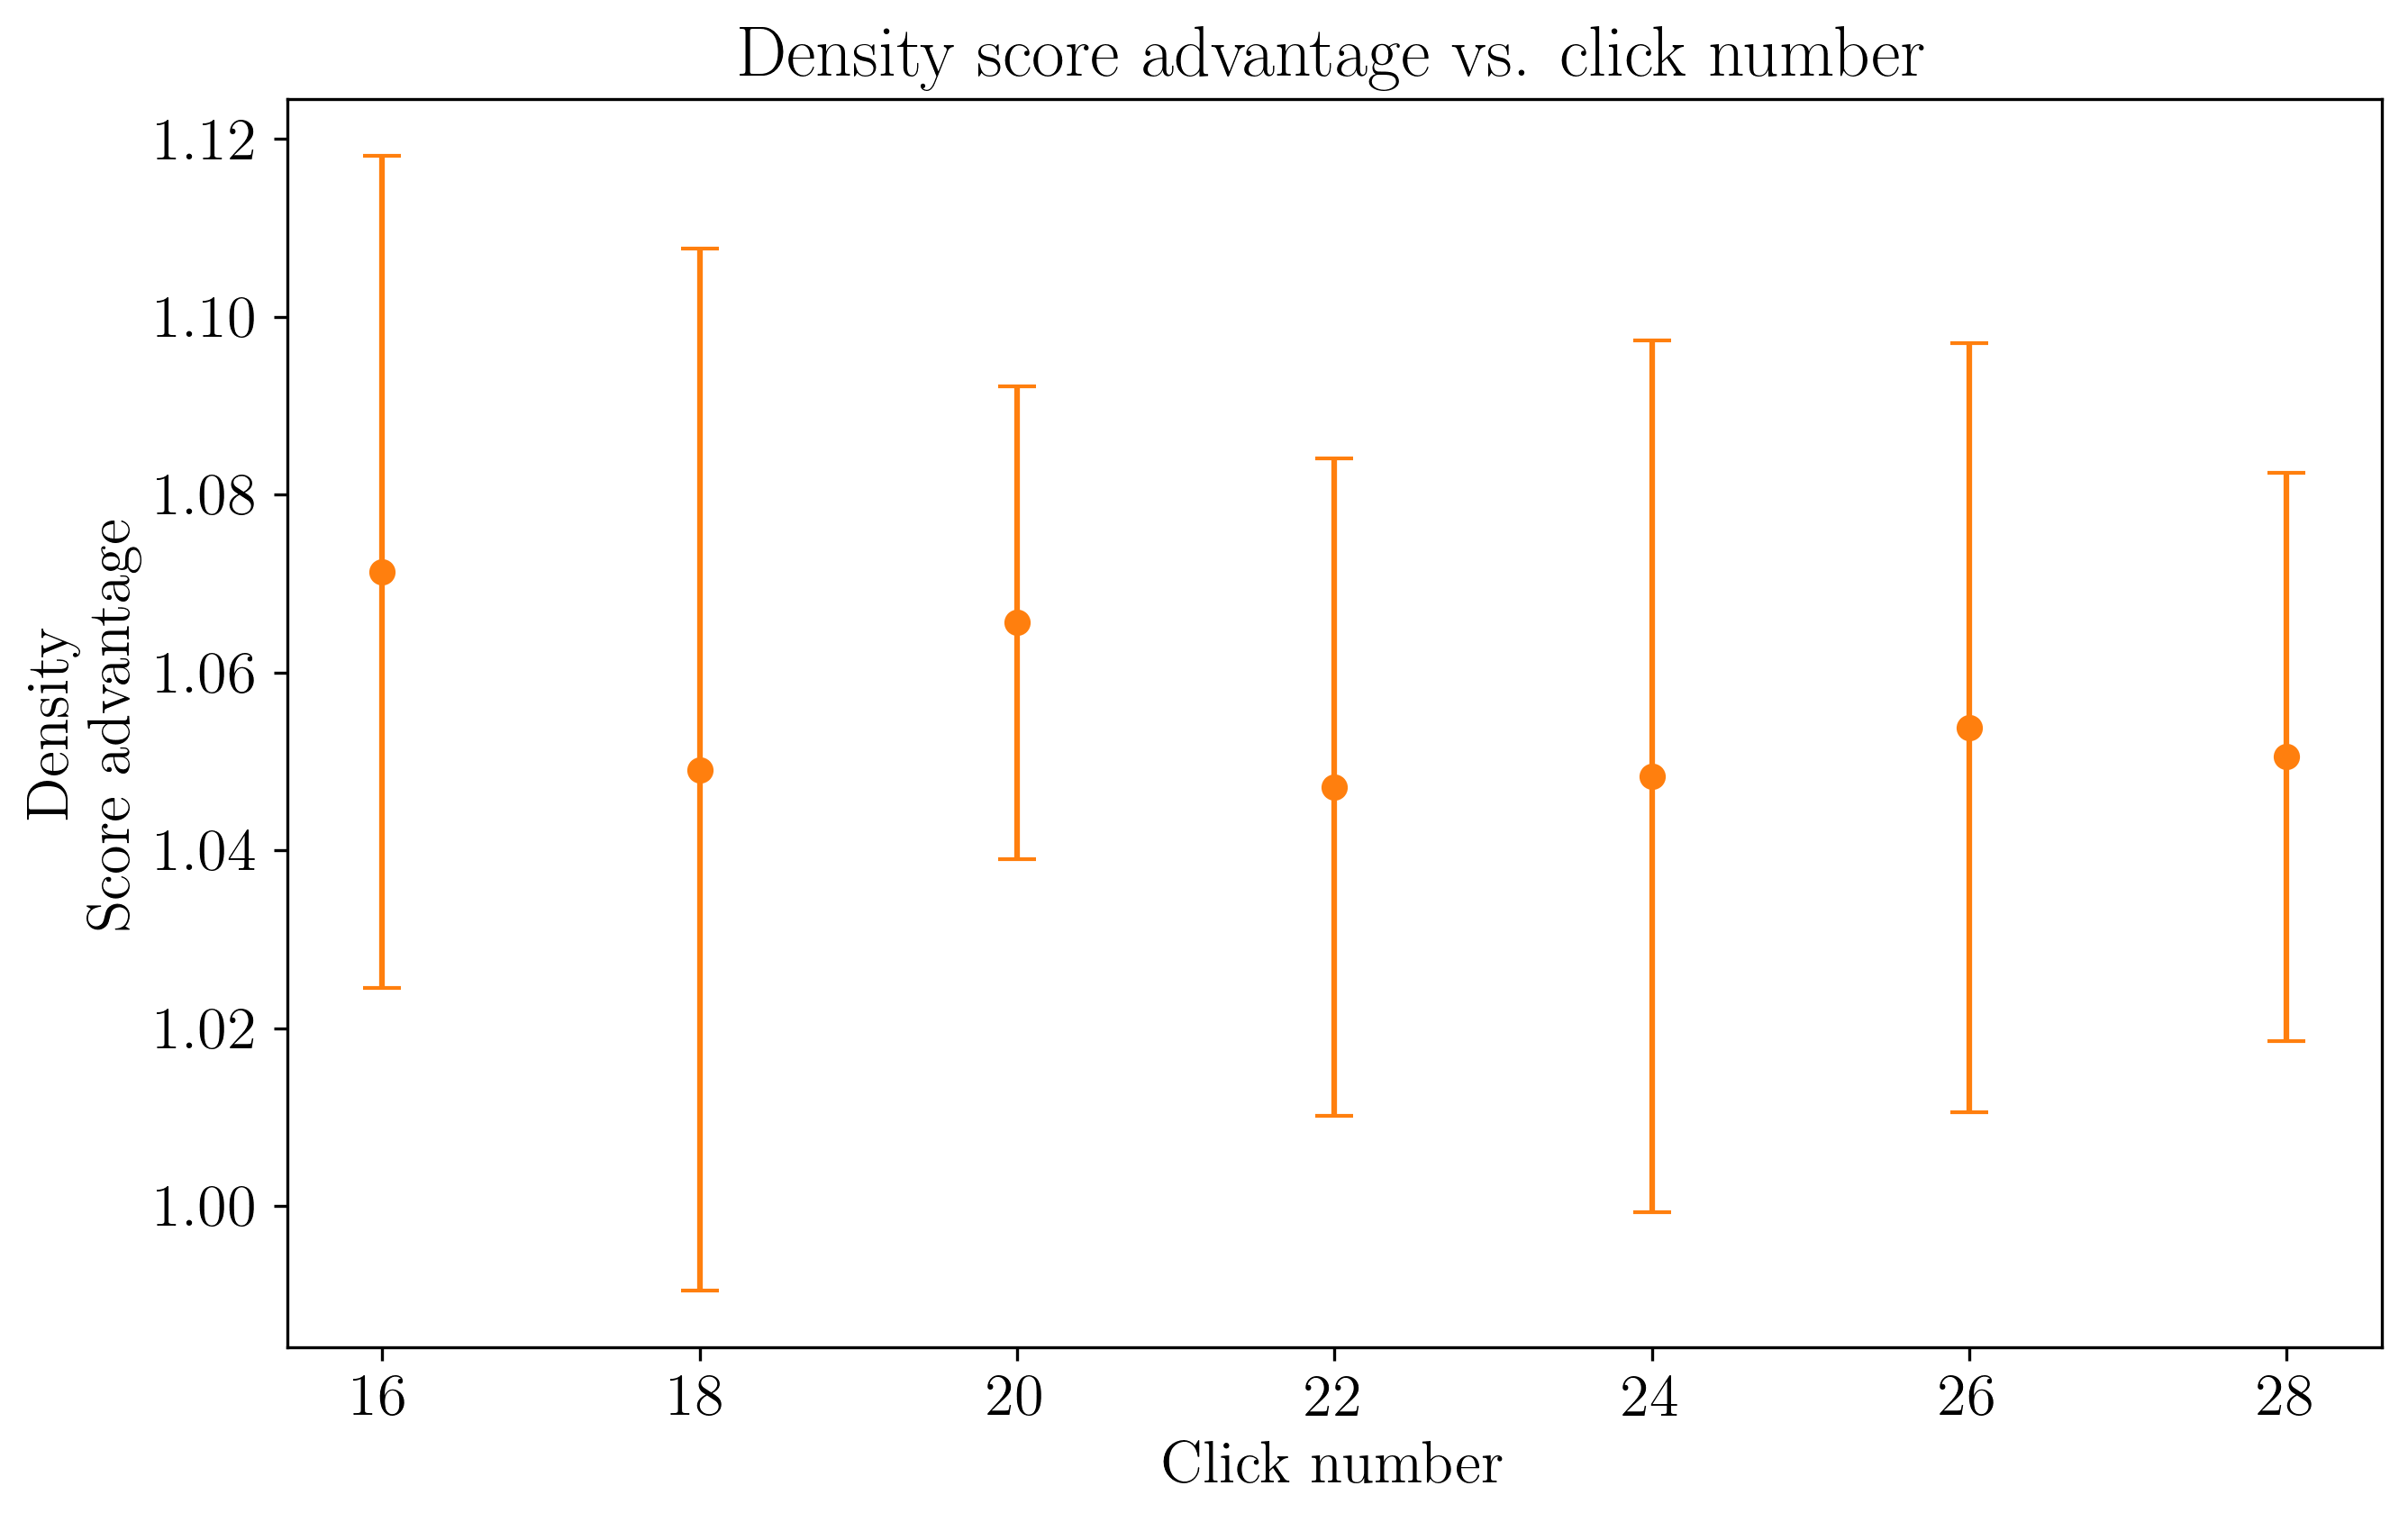

In [16]:
# Plot the density score advantage versus click number
c = 0.4
iteration = 100
mixing_time = 1000
click_number_list = [16, 18, 20, 22, 24, 26, 28]

plt.figure(figsize=(10, 6), dpi=300)
for k in click_number_list:
    best_density = np.zeros(10)
    glauber_best_density = np.zeros(10)
    modified_glauber_best_density = np.zeros(10)
    for i in tqdm(range(10)):
        _, _, best_density[i] = random_search(G0, k, iteration)
        _, _, glauber_best_density[i] = glauber_random_search(G0, k, c, iteration, mixing_time)
        # _, _, modified_glauber_best_hafnian[i] = modified_glauber_random_search(G1, k, c, iteration, mixing_time)
    score_advantage = glauber_best_density / best_density
    np.save(f"./Data/{n}/density_score_advantage_{k}.npy", score_advantage)
    mean = np.mean(score_advantage, axis=0)
    std = np.std(score_advantage, axis=0)
    plt.errorbar(k, mean, yerr = std, fmt='o', color='C1', ecolor='C1', capsize=5)
    
plt.xlabel('Click number')
plt.ylabel('Density \n Score advantage')
plt.title('Density score advantage vs. click number')
plt.savefig('./Figure/density_score_advantage.pdf')
plt.show()

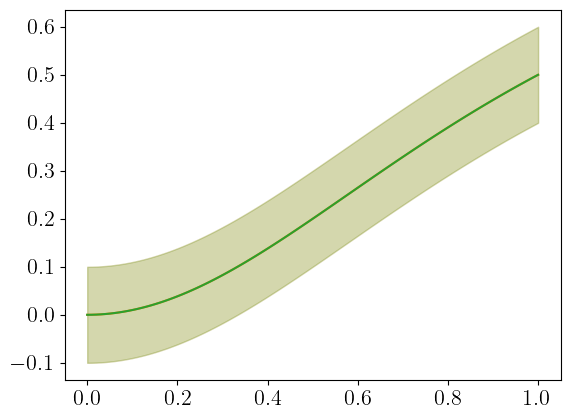

In [7]:
x = np.linspace(0, 1, 100)

plt.plot(x, x**2 / (1 + x**2), color='C1', label='Glauber Dynamics')
plt.fill_between(x, x**2 / (1 + x**2) - 0.1, x**2 / (1 + x**2) + 0.1, color='C1', alpha=0.2)
plt.plot(x, x**2 / (1 + x**2), color='C2', label='Modified Glauber Dynamics')
plt.fill_between(x, x**2 / (1 + x**2) - 0.1, x**2 / (1 + x**2) + 0.1, color='C2', alpha=0.2)